In [45]:
import numpy as np
import matplotlib.pyplot as pl
import emcee
import corner
%matplotlib inline

# Introduction
The aim of this study is analyze whether it is possible to infer the statistical properties of the magnetic field vector in the solar surface only from measurements of the circular polarization, which is just sensitive to the line-of-sight component of the field. If this turns out to be possible, there is a vast amount of data that can be analyzed.

The idea is to observe the field at different positions on the solar disk and use this information to infer the field strength, inclination and azimuth distribution on the disk.

In the weak-field limit (when the Zeeman splitting of the line is smaller than its Doppler broadening), it can be proven that the circular polarization signal is proportional to the so-called magnetic flux density $\Phi$, which is just a measure of the amount of magnetic flux that is passing across a surface perpendicular to the line-of-sight and of the size of the observing pixel.

If we have a reference system XYZ, the magnetic field vector $\mathbf{B}$ and the line-of-sight $\mathbf{\Omega}$ are given by

$$
\mathbf{B}=(B\sin \theta_B \cos \phi_B,B\sin \theta_B \sin \phi_B,B\cos \theta_B) \\
\mathbf{\Omega}=(\sin \theta \cos \phi,\sin \theta \sin \phi,\cos \theta),
$$
where $B$, $\theta_B$ and $\phi_B$ are the spherical components of the magnetic field, while $\theta$ and $\phi$ define the direction of observation. The component along the line-of-sight of the field is then given by:

$$
B_\mathrm{LOS} = B \sin\theta \sin \theta_B \cos(\phi-\phi_B) + B \cos\theta_B \cos\theta.
$$

The question is, then, can we obtain the statistical properties of $B$, $\theta_B$ and $\phi_B$ from the observation of pixels at many different values of $\theta$ and $\phi$? The problem can be slightly simplified because one can assume that $\phi_B$ is uniformly distributed in the interval $[0,2\pi]$.

# Bayesian hierarchical model
We propose to solve this problem using a Bayesian hierarchical model. We model the prior distribution for $\theta_B$ and
$B$ using a certain parametric form and we aim to inferring the parameters of the priors from a sample of pixels. The full posterior is then:

$$
p(\{B_i\},\{{\theta_B}_i\} \{{\phi_B}_i\}|\mathbf{\Phi}) = \prod_{i=1}^N p(\Phi_i|B_i,{\theta_B}_i,{\phi_B}_i) p(B_i|\alpha_B) p({\theta_B}_i|\alpha_\theta p({\phi_B}_i) p(\alpha_B) p(\alpha_\theta)
$$

where $\mathbf{\Phi}={\Phi_1,\ldots,\Phi_N}$ is the set of observed magnetic flux densities. The likelihood is given by:

$$
p(\Phi_i|B_i,{\theta_B}_i,{\phi_B}_i) = \frac{1}{\sqrt{2\pi}\sigma_n} \exp \left[ - \frac{(B \sin\theta \sin \theta_B \cos(\phi-\phi_B) + B \cos\theta_B \cos\theta - \Phi_i)^2}{2\sigma_n^2} \right]
$$

Some examples of the expected log-likelihood surfaces for fixed field strength follow:

In [9]:
thB1d = np.linspace(0.0,np.pi,100)
phiB1d = np.linspace(0.0,np.pi,100)
thB, phiB = np.meshgrid(thB1d, phiB1d)

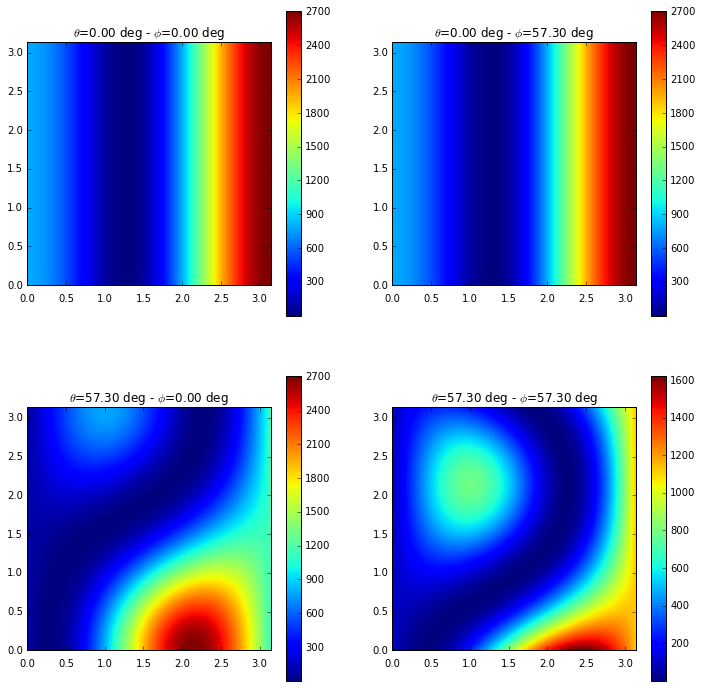

In [21]:
B=40.0
phi=[0.0,1.0]
theta=[0.0,1.0]
Phi=12.0
f, ax = pl.subplots(ncols=2,nrows=2, figsize=(12,12))
for i in range(2):
    for j in range(2):
        chi2 = (B*np.sin(theta[i])*np.sin(thB)*np.cos(phi[j]-phiB)+B*np.cos(thB)*np.cos(theta[i])-Phi)**2
        image = ax[i,j].imshow(chi2, extent=[0.0,np.pi,0.0,np.pi])
        ax[i,j].set_title(r"$\theta$={0:4.2f} deg - $\phi$={1:4.2f} deg".format(theta[i]*180/np.pi,phi[j]*180/np.pi))
        pl.colorbar(image, ax=ax[i,j])

Let us first have a look at a sample for a single pixel.

In [62]:
class singleCase(object):
    def __init__(self, theta, phi, Phi, sigman):
        self.Phi = Phi
        self.theta = theta
        self.phi = phi
        self.sigman = sigman
        
    def transformVariables(self, theta):
        B = np.exp(theta[0])
        thB = 0.0 + (np.pi - 0.0) / (1.0 + np.exp(-theta[1]))
        phiB = 0.0 + (np.pi - 0.0) / (1.0 + np.exp(-theta[2]))
        
        logJacB = theta[0]
        logJacthB = np.log(np.pi - 0.0) - theta[1] - 2.0 * np.log(1.0 + np.exp(-theta[1]))        
        logJacphiB = np.log(np.pi - 0.0) - theta[2] - 2.0 * np.log(1.0 + np.exp(-theta[2]))
        
        return np.asarray([B,thB,phiB]), logJacB + logJacthB + logJacphiB
    
    def logPosterior(self, theta):
        thetaNew, logJac = self.transformVariables(theta)
        B, thB, phiB = thetaNew
        model = B * np.sin(self.theta) * np.sin(thB) * np.cos(self.phi-phiB) + B * np.cos(thB) * np.cos(self.theta)
        logL = -0.5 * (model - self.Phi)**2 / self.sigman**2
        return logL + logJac
    
    def sample(self):
        ndim, nwalkers = 3, 200
        theta0 = np.asarray([0.0, 0.0, 0.0])
        p0 = [theta0 + 0.01*np.random.randn(ndim) for i in range(nwalkers)]
        self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.logPosterior)
        self.sampler.run_mcmc(p0, 1000)
        B = np.exp(self.sampler.chain[:,-20:,0])
        thB = 0.0 + (np.pi - 0.0) / (1.0 + np.exp(-self.sampler.chain[:,-20:,1]))
        phiB = 0.0 + (np.pi - 0.0) / (1.0 + np.exp(-self.sampler.chain[:,-20:,2]))
        return np.vstack([B.flatten(), thB.flatten(), phiB.flatten()])

In [65]:
B = 60.0
thB = 30.0 * np.pi / 180.0
phiB = 45.0 * np.pi / 180.0
theta = 40.0 * np.pi / 180.0
phi = 50.0 * np.pi / 180.0
sigman = 0.5
Phi = B * np.sin(theta) * np.sin(thB) * np.cos(phi-phiB) + B * np.cos(thB) * np.cos(theta)
Phi += np.random.normal(loc=0.0, scale=sigman)
out = singleCase(theta, phi, Phi, sigman)
samples = out.sample()

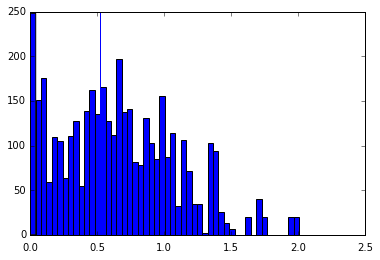

In [66]:
h = pl.hist(samples[1,:], bins=50)
pl.axvline(thB)

The idea would be then to parameterize the distributions $p({\theta_B}_i|\alpha_\theta)$ and $p(B_i|\alpha_B)$ and assume that the one of the azimuth is flat and use the importance sampling trick to resample samples obtained with an interim prior. Any ideas? Any guess that this will work?